In this tutorial, we will illustrate ProSRS algorithm for advanced users. We will use the same 2D function as that in ``basic_general.ipynb``:
<img width="354" alt="demo_function" src="https://user-images.githubusercontent.com/8780593/53434522-71f49500-39bc-11e9-81e1-a0f2121dbb37.png">
where $\epsilon$ is normally distributed with mean 0 and standard deviation 0.1. 

Here we will show an example, where the optimization function is not explicitly provided, and only the method of the parallel evaluations of the function is supplied. This running mode can be particularly useful for the cases, where the parallel evaluation method has been already implemented and encapsulated prior to the optimization.

In [1]:
import prosrs
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool

In [2]:
# Define optimization prblem
name = 'Advanced_Demo_2' # problem name
domain = [(-5., 5.), (-5., 5.)] # function domain
x_var = ['x', 'y'] # independent variable names
y_var = 'z' # response variable name
prob = prosrs.Problem(domain, name=name, x_var=x_var, y_var=y_var) # create problem object (Note: no optimization function is supplied)
print(prob) # show problem info

Optimization problem:
- Name: Advanced_Demo_2
- Dimension: 2
- Domain: {'x': (-5.0, 5.0), 'y': (-5.0, 5.0)}
- Optimization function: not provided
- Response variable: 'z'
- Global minimum: unknown
- Global minimum locations: unknown


In [3]:
# Set up optimization (the same as in ``basic_general.ipynb``)
n_worker = 12 # number of workers
n_cycle = 1 # number of optimization cycles
optimizer = prosrs.Optimizer(prob, n_worker, n_cycle=n_cycle) # create optimizer object

In [4]:
# Show optimization configuration
optimizer.show(select=['config'])

Optimization configuration:
- Number of workers: 12
- Termination criterion: stop after completing 1 optimization cycles
- Resuming from the last run?  No
- Output directory: 'out'


In [5]:
# Define a function that encapsulates parallel evaluations.
def parallel_eval(pts, seeds, n_proc):
    """
    Evaluate a function in parallel.
    
    Args:
        
        pts (2d array): Points to be evaluated. Each element (row) is one point. Shape: (n, d).
        
        seeds (1d array): Random seed for each point in `pts`. Shape: (n,).
        
        n_proc (int): Number of parallel processes for Pool object.
    
    Returns:
    
        vals (1d array): Function value for each point in `pts`. Shape: (n,).
        
    Note: 
        
        This function essentially tries to parallelize the following for loop:
        
        vals = np.zeros(0)
        for pt, seed in zip(pts, seeds):
            np.random.seed(seed)
            vals = np.append(vals, f(pt))
    """
    def f(x):
        """
        A function to be optimized over.
        
        Args:
        
            x (1d array): Function input.
    
        Returns:
    
            y (float): Function output.
        """
        sd = 0.1
        y = x[0]**2+x[1]**2+np.random.normal(0, sd)
        return y
    
    def atomic_eval(arg):
        """
        An atomic evaluation wrapper.
        
        Args:
        
            arg (tuple): Function argument = (pt, seed), where
                `pt` is the point to be evaluated and `seed` 
                is the random seed.
        
        Returns:
        
            y (float): Function value.
        """
        pt, seed = arg
        np.random.seed(seed)
        y = f(pt)
        return y

    p = Pool(nodes=n_proc) # create a pool object
    args = [(pt, seed) for pt, seed in zip(pts, seeds)]
    vals = np.array(p.map(atomic_eval, args))
    
    return vals

In [6]:
# Run optimization
while not optimizer.is_done():
    
    print('\nIteration %d:' % (optimizer.i_iter+1))
    
    # propose new points
    new_pt = optimizer.propose(verbose=True)
    
    # evaluate proposed points using customized functions
    new_val = parallel_eval(new_pt, optimizer.eval_seeds, n_worker)
    print('Evaluated proposed points using the encapsulated evaluation function.')
    
    # update optimizer state with the new evaluations
    optimizer.update(new_pt, new_val, verbose=True)


Iteration 1:
Proposing new points (DOE) .......... Done (time took: 8.76e-06 sec).
Evaluated proposed points using the encapsulated evaluation function.
Updating optimizer state .......... Done (time took: 6.91e-04 sec).

Iteration 2:
Building RBF regression model .......... Done (time took: 2.67e-02 sec).
Proposing new points .......... Done (time took: 4.18e-03 sec).
Evaluated proposed points using the encapsulated evaluation function.
Updating optimizer state .......... Done (time took: 5.89e-04 sec).

Iteration 3:
Building RBF regression model .......... Done (time took: 2.69e-02 sec).
Proposing new points .......... Done (time took: 5.49e-03 sec).
Evaluated proposed points using the encapsulated evaluation function.
Updating optimizer state .......... Done (time took: 5.97e-04 sec).

Iteration 4:
Building RBF regression model .......... Done (time took: 3.08e-02 sec).
Proposing new points .......... Done (time took: 4.92e-03 sec).
Evaluated proposed points using the encapsulated 

In [7]:
# Show optimization result
optimizer.show(select=['result']) 

Optimization result:
- Best point:
  x = 0.0675409, y = 0.0368185
- Best (noisy) value:
  z = -0.267438


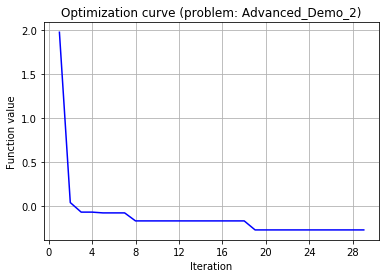

In [8]:
# Visualize optimization results
optimizer.visualize(select=['optim_curve']) # optimization curve

In [9]:
# Set parameters
n_top = 100 # use top 100 points as the candidates for the posterior best point
n_repeat = 100 # number of Monte Carlo repeats
seed = 1 # random seed

# Perform posterior evaluations
top_pt, _, _ = optimizer.top_pts(n_top=n_top) # get top points
top_pt_mc = top_pt[np.outer(range(n_top), np.ones(n_repeat, dtype=int)).flatten()] # duplicate each point in `top_pt` for `n_repeat` times
top_seed_mc = seed+np.arange(n_top*n_repeat, dtype=int) # random seeds of Monte Carlo evaluations
top_val_mc = parallel_eval(top_pt_mc, top_seed_mc, n_worker) # Monte Carlo evaluations for the top points
top_val = top_val_mc.reshape((n_top, n_repeat))
top_mean_val = np.mean(top_val, axis=1) # Monte Carlo mean estimates for each point in `top_pt`
top_std_val = np.std(top_val, axis=1, ddof=1) # standard deviation estimates for each point in `top_pt`

# Sort the top points by mean estimates
sort_ix = np.argsort(top_mean_val)
top_pt = top_pt[sort_ix]
top_mean_val = top_mean_val[sort_ix]
top_std_val = top_std_val[sort_ix]

# Find the posterior best point
best_point = top_pt[0] # the point with the lowest Monte Carlo mean estimate
best_value = top_mean_val[0] # Monte Carlo mean estimate for the `best_point`
print('Best point: %s' % str(best_point))
print('Best (mean) value: %g' % best_value)

Best point: [-0.00398517  0.01883326]
Best (mean) value: -0.0168467
